# NLP_GoingDeeper | P-8. Seq2Seq_Translation_Kor2Eng
---
- 한국어 문장을 입력으로 하여 영어로 번역된 문장을 출력하는 번역기를 만들어봅니다. 
- Seq2Seq는 두 개의 RNN 모듈을 Encoder-Decoder 구조로 결합하여 사용합니다.
- Seq2Seq는 번역기에 최적화되어있기 때문에, Seq2Seq 기반 번역기를 직접 만들어봅니다. 
-  한국어-영어 말뭉치를 사용합니다. 
- (한국어 시각화를 위한 준비) matplotlib라이브러리의 기본 폰트는 한국어를 지원하지 않기 때문에, Attention Map을 확인하기 위해, 한국어를 지원하는 폰트로 변경해줍니다. 

In [1]:
# 항상 하는 미친짓 ^^ 
import time
start_time = time.time()

# 📑 프로젝트 미션 : 한국어-영어 번역기 만들기 📑

## 필요 라이브러리 로드

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = 'C:/Users/Noah/AppData/Local/Microsoft/Windows/Fonts/NanumGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager.findfont(font)
print("완료!")

import time
import re
import os
import io

from konlpy.tag import Mecab
from collections import Counter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm    # tqdm
import random

완료!


# 0. 데이터 불러오기
- korean-english-park.train dataset에는 약 9만 4천개의 한국어-영어 pair data가 포함되어 있습니다. 

In [3]:
cache_dir = 'C:/Users/Noah/aiffel/GoingDeeper/AIFFEL_GOINGDEEPER_NLP/G-8/s2s_translation'
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin = 'https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    cache_dir = cache_dir,
    extract=True
    )

## 데이터 가져와서 살펴보기

아래 데이터를 통해 **한국어 데이터와 영어 데이터는 각각 94123개**가 있음을 알 수 있습니다.

위 값은 각 언어별 훈련 데이터와 검증 데이터의 합으로 볼 수 있습니다.

### 한국어 & 영어 훈련 데이터

In [4]:
path_to_ko = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"
path_to_en = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"
#path_to_ko_test = os.path.dirname(path_to_zip)+"/korean-english-park.test.ko"
#path_to_en_test = os.path.dirname(path_to_zip)+"/korean-english-park.test.en"
#path_to_ko_dev = os.path.dirname(path_to_zip)+"/korean-english-park.dev.ko"
#path_to_en_dev = os.path.dirname(path_to_zip)+"/korean-english-park.dev.en"

In [5]:
with open(path_to_ko, "r", encoding='utf8') as f:
    raw_ko = f.read().splitlines()
with open(path_to_en, "r", encoding='utf8') as f:
    raw_en = f.read().splitlines()
print("Data Size:({},{})".format(len(raw_ko), len(raw_en)))
print("Example:")

# for sen in list(zip(raw_ko, raw_en))[0:100][::20]: print(">>", sen)

cnt = 0
for ko, en in zip(raw_ko, raw_en):
    print(f">>\n한국어 : {ko}\n영어 : {en}\n")
    cnt += 1
    if cnt == 5:
        break

Data Size:(94123,94123)
Example:
>>
한국어 : 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
영어 : Much of personal computing is about "can you top this?"

>>
한국어 : 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
영어 : so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.

>>
한국어 : 그러나 이것은 또한 책상도 필요로 하지 않는다.
영어 : Like all optical mice, But it also doesn't need a desk.

>>
한국어 : 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
영어 : uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.

>>
한국어 : 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
영어 : Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror atta

## 데이터 정제하기

**한국어-영어 번역기의 데이터 정제는 크게 다음과 같은 방법을 따릅니다.**

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하는데, 이 때 데이터의 병렬 쌍이 흐트러지지 않도록 합니다.
2. 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
3. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않으므로, 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의해야 합니다.
4. 타겟 언어인 영문엔 start 토큰과 end 토큰을 추가하고 split() 함수를 이용하여 토큰화 진행하면 됩니다.
5. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. 설치가 안 되어 있다면 아래 참고 링크를 따라 설치를 진행합니다.

**KoNLPy 설치 참고 : https://konlpy.org/ko/latest/install/#ubuntu**

KoNLPy를 설치해 보셨다면 설치과정이 생각보다 꽤 걸렸을 것입니다.

아마도 거기에 있는 모든 데이터를 사용한다면 학습이 매우 오래 걸릴 것 같아 보입니다.

그래서 본 프로젝트에서는 **cleaned_corpus로부터 토큰의 길이가 44 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축합니다.**

In [6]:
cleaned_corpus = list(set(zip(raw_ko, raw_en)))
print(cleaned_corpus[0:3], '\n')
print('정제된 한영 코퍼스 개수는', len(cleaned_corpus), '개 입니다')

[('개트윅 공항 비행장 도로에 그려진, 봉을 잡고 있는 전라의 댄서 실루엣이 영국 시골 지방을 어지럽히고 있다.', "This is not the first time that the company's ads have appeared near the airport."), ('이 과정을 수강하면 당신이나 당신의 회사는 고용기회균등법을 어기지 않게 될 것이다.', 'Take a course that will keep you and your company from violating equal-opportunity law.'), ('그녀는 "어린이에 대한 상업적인 성적 착취는 어린이의 인권을 심각하게 침해하는 것"이라고 로이터 통신에 말했다.', 'She told Reuters that "commercial sexual exploitation of children was a grave violation of their human rights."')] 

정제된 한영 코퍼스 개수는 78968 개 입니다


In [7]:
import pandas as pd
pair_df = pd.DataFrame({'Korean':raw_ko, 'English':raw_en})
pair_df

,Korean,English
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [8]:
pair_df[pair_df.duplicated()]

,Korean,English
7789,이들 의원 중 1명은 빌 클린턴 전 대통령이 지난 몇 주간 부인 힐러리에게 오바마의...,"One of the lawmakers said Clinton's husband, f..."
9925,*판매 제품,The goods
10070,* 알아두면 좋은 것:,Good to know:
10074,* 알아두면 좋은 것:,Good to know:
10079,* 알아두면 좋은 것:,Good to know:
...,...,...
93792,"힐러리 클린턴, 북한 방문할까",Would Hillary Clinton visit North Korea?
93793,"이라크 새 의회, 첫 개정",Iraq’s new assembly is going to hold its first...
93933,"노 대통령 검찰, 민주적 통제 받아야 2005.12",Roh says prosecutors need civilian control.
94002,"카우치 멤버, 사전 모의 시인 2005.09",Members of The Couch planned it before the show.


- 약 1만 5천여개의 중복 데이터쌍이 존재합니다. 

In [9]:
pair_df.drop_duplicates(inplace=True)
print(pair_df.shape)
pair_df[pair_df.duplicated()]

(78968, 2)


,Korean,English


- 중복 데이터쌍 제거 후, 약 7만 8천여개의 데이터쌍이 남았습니다.

## 1-2. preprocessing
- 한글에 적용할 수 있는 정규식을 추가하여 preprocessing을 진행합니다.
- 타겟 언어인 영문에는 \<start\> 토큰과 \<end\>토큰을 추가하고 split() 함수를 이용하여 토큰화합니다.

In [10]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    
    #- 단어와 구두점(punctuation)사이의 거리 생성
    sentence = re.sub(r"([?.!,])", r" \1", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) #- 여러개의 공백은 하나의 공백으로 바꾸기
    # (ㄱ-ㅎ, ㅏ-ㅣ 가-힣, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣?.!,]+", " ", sentence)
    sentence = sentence.strip() #- 양쪽 공백 제거
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [11]:
enc_corpus = []
dec_corpus = []

for pair in cleaned_corpus:
    ko, en = pair[0], pair[1]
    enc_corpus.append(preprocess_sentence(ko))
    dec_corpus.append(preprocess_sentence(en, s_token=True, e_token=True))

print("Korean:", enc_corpus[2500])
print("English:", dec_corpus[2500])

Korean: 흰 티셔츠에 일자리 구함 I NEED A JOB ! 이라는 크고 진한 글자의 제목 아래로 자신의 이력을 써내려 갔다 .
English: <start> The credentials on the white T shirt are listed below a boldface heading <end>


In [12]:
for i in range(3):
    print("한국어 : ", enc_corpus[i])
    print("영어 : ", dec_corpus[i], '\n')

한국어 :  개트윅 공항 비행장 도로에 그려진 , 봉을 잡고 있는 전라의 댄서 실루엣이 영국 시골 지방을 어지럽히고 있다 .
영어 :  <start> This is not the first time that the company s ads have appeared near the airport . <end> 

한국어 :  이 과정을 수강하면 당신이나 당신의 회사는 고용기회균등법을 어기지 않게 될 것이다 .
영어 :  <start> Take a course that will keep you and your company from violating equal opportunity law . <end> 

한국어 :  그녀는 어린이에 대한 상업적인 성적 착취는 어린이의 인권을 심각하게 침해하는 것 이라고 로이터 통신에 말했다 .
영어 :  <start> She told Reuters that commercial sexual exploitation of children was a grave violation of their human rights . <end> 



# 데이터 토큰화
- tokenize() 함수를 사용해 데이터를 텐서로 변환하고 각 tokenizer를 얻습니다. 
- 단어의 수는 30,000 개로 정했습니다. 
- 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. 
- cleaned_corpus 로부터 토큰의 길이가 40이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축합니다. 
- keras Tokenizer.index에서 num_words인자 설정에 따라 이후 사용되는 vocab의 사이즈가 결정됩니다. 
- 데이터가 많지 않아 훈련 데이터와 검증 데이터를 따로 나누지는 않겠습니다. 
- 참고 : [What does Keras Tokenizer num_words specify?](https://stackoverflow.com/questions/64158898/what-does-keras-tokenizer-num-words-specify)

In [13]:
def tokenize(corpus, vocab_size = 30000, maxlen=40, mecab=False):
    
    if mecab:
        mecab = Mecab('C:/mecab/mecab-ko-dic')
        x_train = []
        for sen in corpus:
            x = mecab.morphs(sen)
            x_train.append(x)
        words = np.concatenate(x_train).tolist()
        counter = Counter(words)
        counter = counter.most_common(vocab_size)
        vocab = ['','']+[key for key,_ in counter]
        word_to_index = {word : index for index, word in enumerate(vocab)} #- word : index 사전
        
        word_to_index["<PAD>"] = 0
        word_to_index["<UNK>"] = 1
        
        def wordlist_to_indexlist(wordlist):
            return [word_to_index[word] if word in word_to_index else word_to_index["<UNK>"] for word in wordlist]
        
        x_train = list(map(wordlist_to_indexlist, x_train))
        

        index_to_word = {index:word for word, index in word_to_index.items()}

        x_train = pad_sequences(x_train,
                        value=word_to_index["<PAD>"],
                        padding='post', # 혹은 'pre'
                        maxlen=maxlen)
        
        return x_train, word_to_index

    else:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, filters='')
        tokenizer.fit_on_texts(corpus)
        tensor = tokenizer.texts_to_sequences(corpus)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, maxlen=maxlen, padding='post')
        return tensor, tokenizer

In [14]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus, vocab_size = 30000-3, maxlen=40, mecab=True)
dec_tensor, dec_tokenizer = tokenize(dec_corpus, vocab_size = 30000+1, maxlen=40, mecab=False)

# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = \
# train_test_split(enc_tensor, dec_tensor, test_size=0.2)

In [15]:
print("Korean Vocab Size:", len(enc_tokenizer))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 30000
English Vocab Size: 44689


## Attention 기반 Seq2seq 모델 설계

input한 한국어를 그럴듯한 영어로 잘 번역해줄 수 있도록 Attention 기반 Seq2seq 모델을 설계하는 스텝입니다.

앞서 만든 모델에 **Dropout 모듈**을 추가하면 성능이 좋아지는지도 확인해 보면 좋습니다.

Embedding Size와 Hidden Size는 실험을 통해 적당한 값을 맞춰 주도록 합니다.

아까 살펴봤던 **Bahdanau Attention** 써보죠 뭐.. 😊😊

In [16]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)
        
        # score shape == (batch_size, max_length, 1)
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # attention weights shape == (batch_size, max_length, 1)
        attn = tf.nn.softmax(score, axis=1)
        
        # context vector shape after sum == (batch_size, hidden_size)
        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       dropout=0.3,
                                       return_sequences=True)
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

In [18]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       dropout=0.3,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
    
    
    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [19]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)


# sample input
# sequence_len = 30

# sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
# sample_output = encoder(sample_enc)

# print('Encoder Output:', sample_output.shape)

# sample_state = tf.random.uniform((BATCH_SIZE, units))

# sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
#                                     sample_state, sample_output)

# print('Decoder Output :', sample_logits.shape)
# print('Decoder Hidden State :', h_dec.shape)
# print('Attention :', attn.shape)

## Optimizer & Loss

앞에 연습과정에서 살펴본 모델 설계에서의 Encoder-Decoder 구조의 경우 입출력이 단순하지 않아 **학습 과정을 직접 정의해줘야 했습니다**

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## train_step

In [21]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_out = encoder(src) # context vector 생성
        h_dec = enc_out[:, -1] # t=0일 때 Decoder의 Hidden State는 Encoder의 Final State로 정의
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1) # Decoder에 입력으로 전달할 <start>토큰 문장 생성
        
        for t in range(1, tgt.shape[1]): # 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)
            
            loss += loss_function(tgt[:, t], pred) # 예측된 단어와 정답 간의 loss를  구함
            dec_src = tf.expand_dims(tgt[:, t], 1) # t=1의 정답 단어를 다음 입력으로 사용
            
    batch_loss = (loss / int(tgt.shape[1]))
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

## 모델 훈련

In [22]:
print('시간 좀 걸릴거에요~ 화이팅..👍👍')

from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_tensor.shape[0], BATCH_SIZE)) # 각 배치의 시작 인덱스를 idx_list 배열에 저장
    random.shuffle(idx_list) # 학습이 원활하게 이루어질 수 있도록 인덱스를 섞음
    t = tqdm(idx_list)
    
    # 각 미니배치를 train_step() 함수에서 학습합니다. train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수입니다.
    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_tensor[idx: idx+BATCH_SIZE],
                                dec_tensor[idx: idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
        
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1)) # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1))) # tqdm

시간 좀 걸릴거에요~ 화이팅..👍👍


Epoch 10: 100%|███████████████████████████████████████████████████████| 1234/1234 [05:58<00:00,  3.45it/s, Loss 1.5351]


## 모델 평가

공식적인 마지막 스텝이 되겠습니다.

모델의 훈련이 정상적으로 되었다면, **이 번역기 모델의 성능이 어떤지 살펴볼 필요가 있겠죠? 😎**

In [23]:
def evaluate(sentence, encoder, decoder):
    mecab = Mecab('C:/mecab/mecab-ko-dic')
    attention = np.zeros((dec_tensor.shape[-1], enc_tensor.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    sentence = mecab.morphs(sentence)
    inputs = [[enc_tokenizer[word] if word in enc_tokenizer else enc_tokenizer["<UNK>"] for word in sentence]]
    print(inputs)
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                        value=enc_tokenizer["<PAD>"],
                        padding='post',
                        maxlen=enc_tensor.shape[-1])
    print(inputs)

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_tensor.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention

In [24]:
def plot_attention(attention, sentence, predicted_sentence):
    sns.set(font='NanumGothic')
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


In [25]:
def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))


지금까지 긴 스텝 밟아오시느라 고생 많으셨습니다!!!

이제 **한국어 노래 가사로 이루어진 문장을 영어로 잘 번역해내는지 확인하는 것으로 프로젝트를 마무리하겠습니다! 👍👍👍**

C:\Users\Noah\AppData\Local\Temp\ipykernel_37856\2031441113.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Noah\AppData\Local\Temp\ipykernel_37856\2031441113.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


[[256, 9, 75, 3415, 2388, 1875, 186, 12, 257]]
[[ 256    9   75 3415 2388 1875  186   12  257    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['좋', '은', '사람', '꼭', '만날', '거', '라', '했', '는데']
Predicted translation: good things are good . <end> 


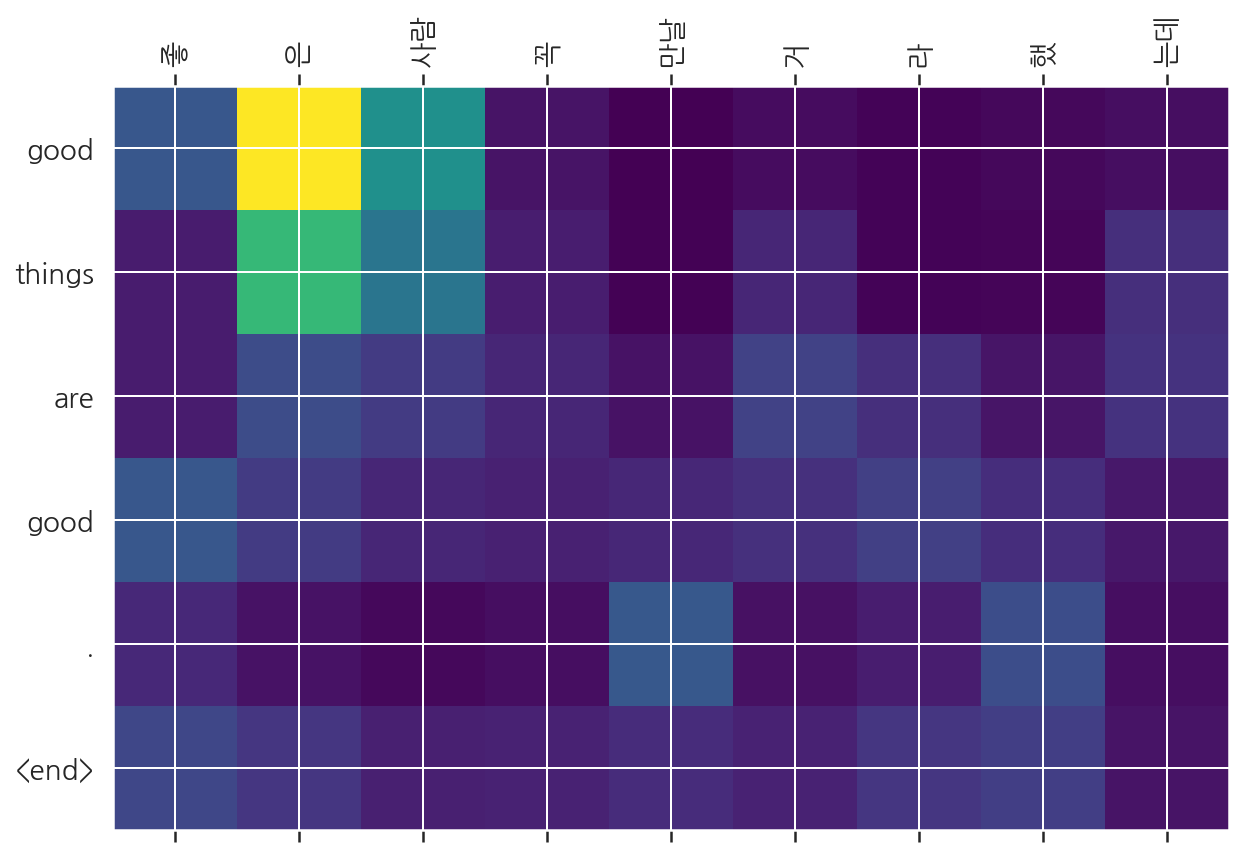

In [26]:
# 예시 1. 씨야,「사랑의 인사」
translate("좋은 사람 꼭 만날 거라 했는데", encoder, decoder)

[[7911, 51, 1, 8402, 4310, 1584, 1875, 602]]
[[7911   51    1 8402 4310 1584 1875  602    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['빛나', '던', '우릴', '영원히', '남겨', '둘', '거', '야']
Predicted translation: a few more than a half baked and a half baked and a half baked and a half baked and a half baked and a half baked and a half baked and a half baked and a half baked and 


C:\Users\Noah\AppData\Local\Temp\ipykernel_37856\2031441113.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Noah\AppData\Local\Temp\ipykernel_37856\2031441113.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


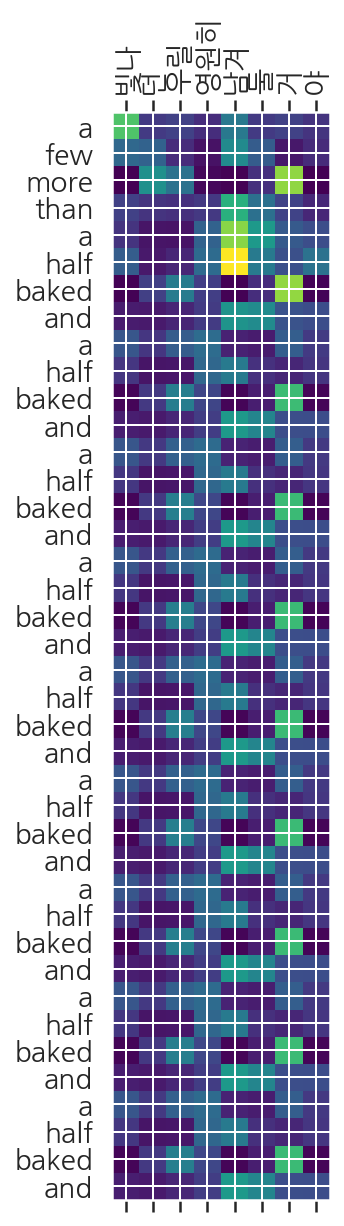

In [27]:
# 예시 2. STAYC,「사랑은 원래 이렇게 아픈 건가요」
translate("빛나던 우릴 영원히 남겨 둘 거야", encoder, decoder)

[[110, 5, 47, 4, 3, 2]]
[[110   5  47   4   3   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is a democrat . <end> 


C:\Users\Noah\AppData\Local\Temp\ipykernel_37856\2031441113.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
C:\Users\Noah\AppData\Local\Temp\ipykernel_37856\2031441113.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


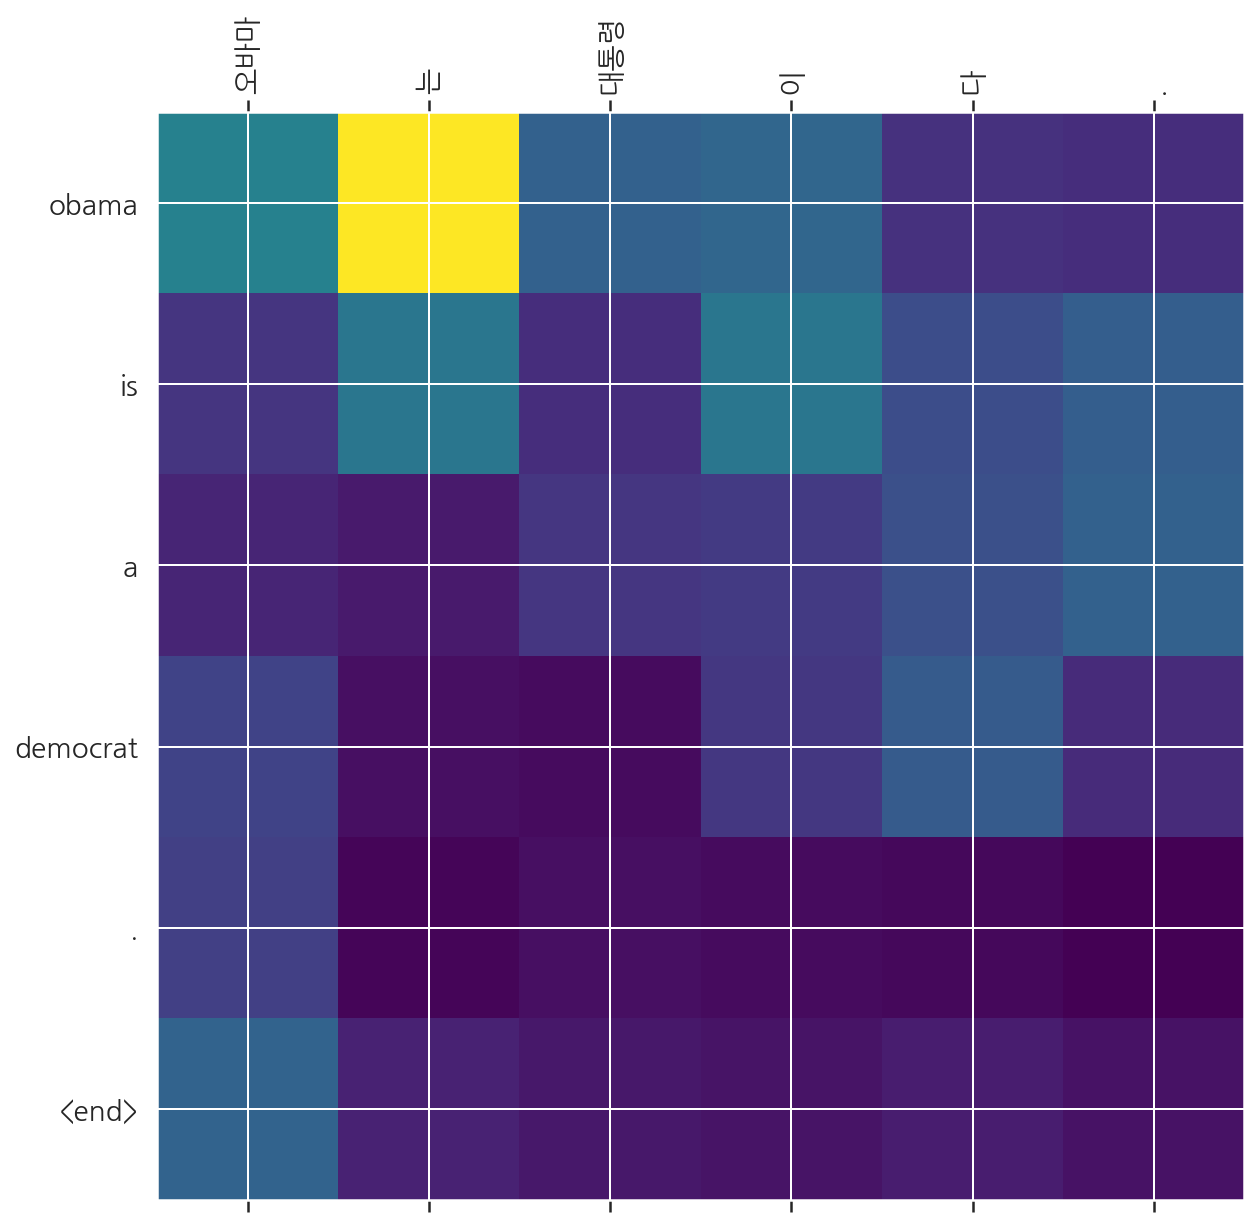

[[514, 15, 9, 321, 577, 8, 1, 2]]
[[514  15   9 321 577   8   1   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they are in continuity . <end> 


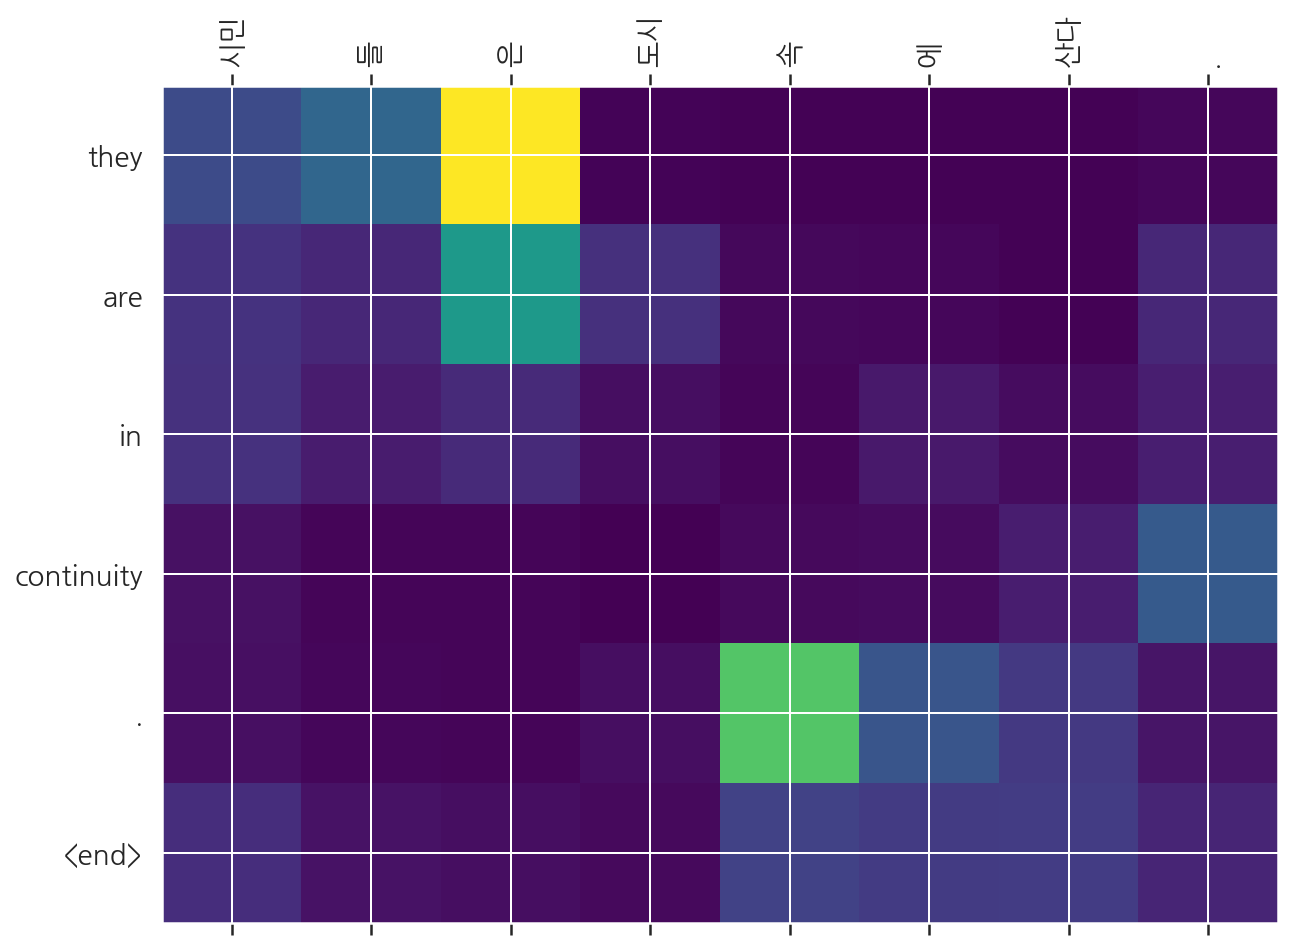

[[2677, 5, 222, 69, 3, 2]]
[[2677    5  222   69    3    2    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: the coffee doesn t know . <end> 


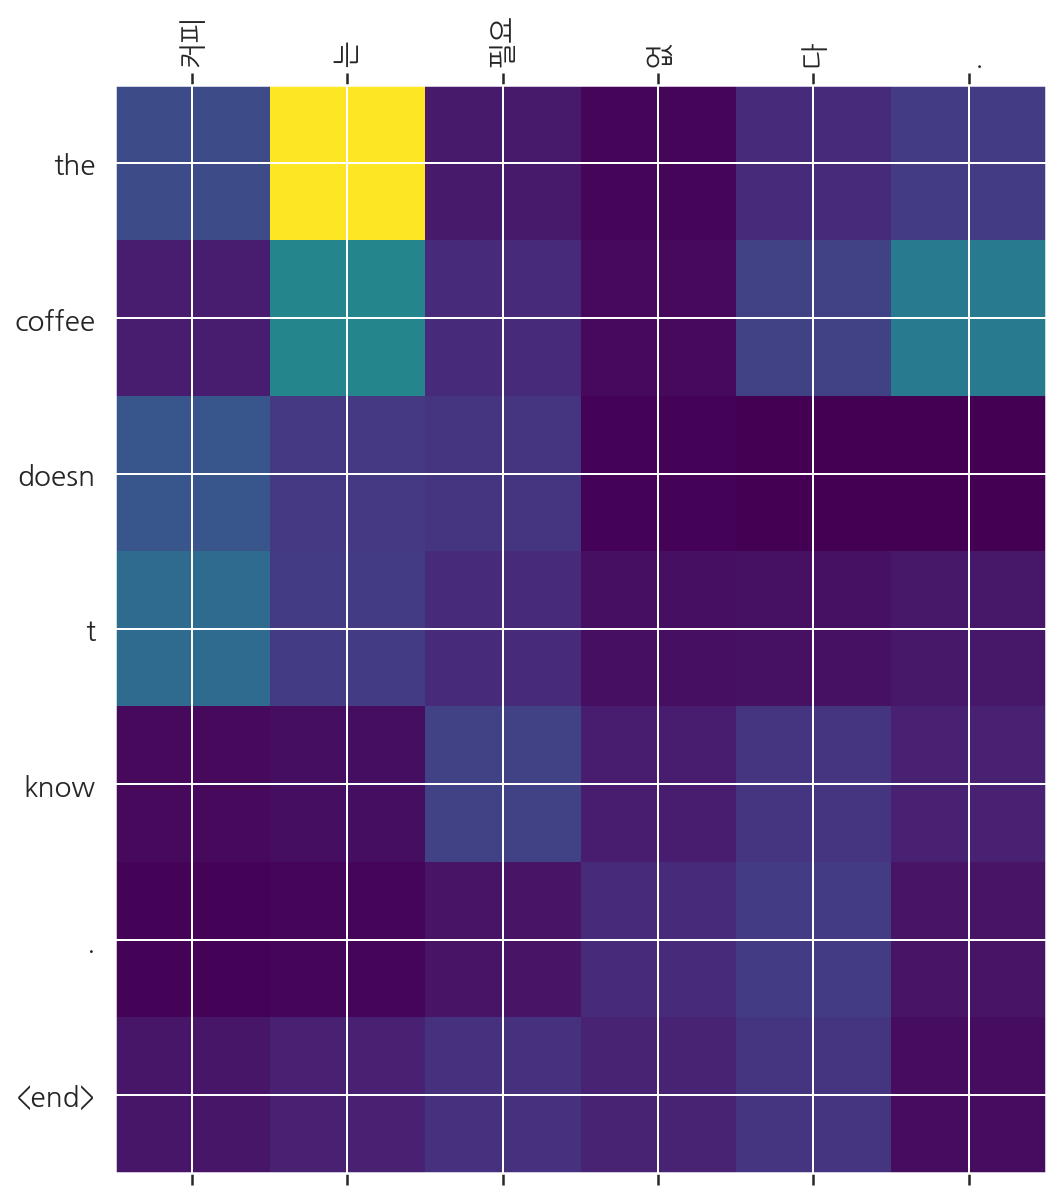

[[6160, 33, 7, 517, 16, 89, 12, 3, 2]]
[[6160   33    7  517   16   89   12    3    2    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]
Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: the dead were killed . <end> 


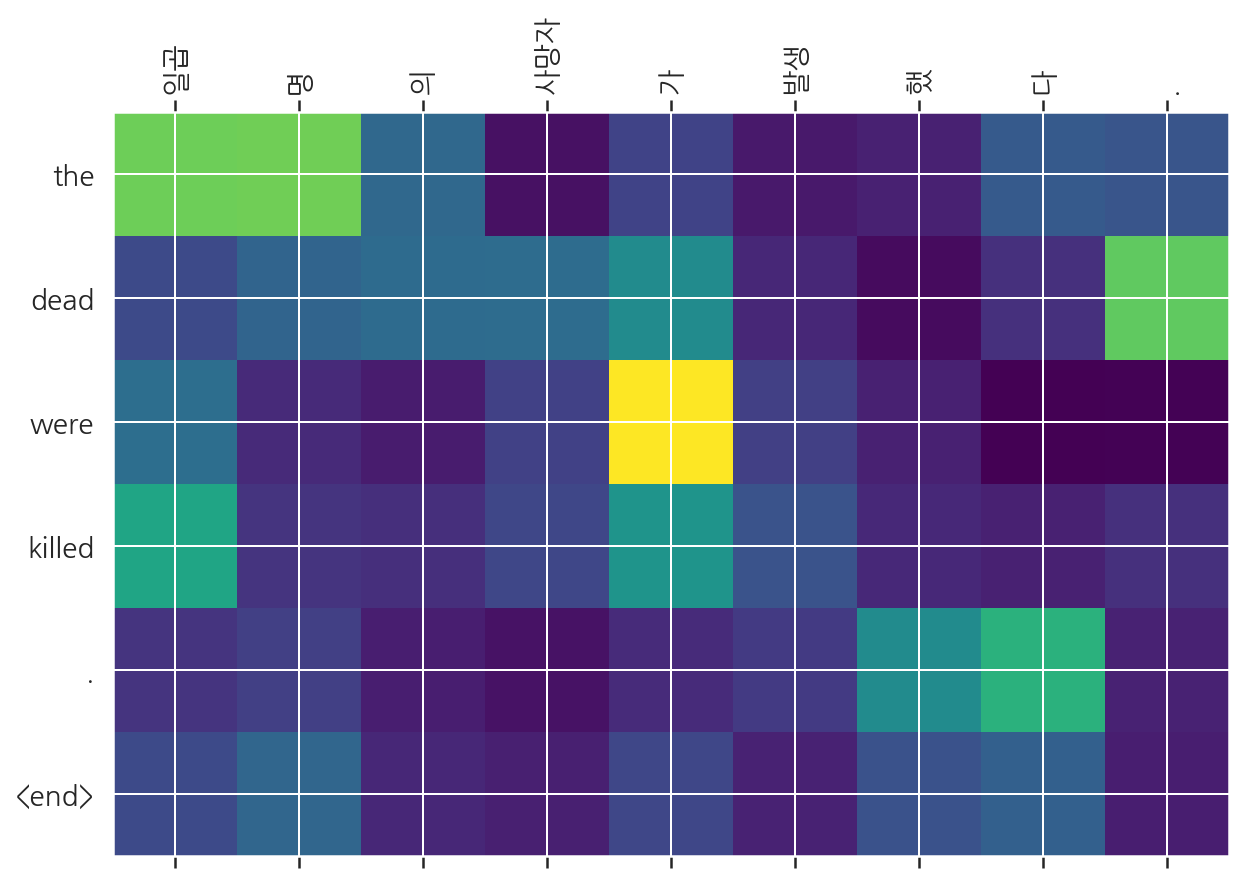

In [28]:
translate("오바마는 대통령이다.", encoder, decoder)
translate("시민들은 도시 속에 산다.", encoder, decoder)
translate("커피는 필요 없다.", encoder, decoder)
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

In [29]:
end_time = time.time()
work_time = round(end_time - start_time)
print(f'총 작업 소요 시간은 약 {work_time}초입니다.')

총 작업 소요 시간은 약 3636초입니다.


# 루브릭 평가
---
1. **번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.**   
    - 한국어는 mecab을 이용해 형태소분석을 진행하였다.


2. **Attentional Seq2seq 모델이 정상적으로 구동된다.**

    - training loss는 점차적으로 줄어드는 것을 볼 수 있었다.


3. **테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.** 
 
     - 의미는 통하는 결과를 얻을 수 있었다. 


    
# 회고
---
## 어려웠던 부분 
- 데이터셋 자체의 신뢰도가 낮았다. 

## 알아낸 점 혹은 모호한 부분 
- mecab으로 형태소 단위로 분해하는 것과 토큰화하는 것을 다르게 하는 것에 대해 배울 수 있었다. 
- 데이터셋을 검증할 수 있는 방법에 대해 알아봐야겠다. 9만 여개의 데이터를 전부 확인할 수 없었다. 
- attention 메커니즘에 대해 직접 구성할 수 있어서 좋았다. 

단어장의 크기를 최소 10000 이상을 전제로 적절히 설정하였으나, 결국 한 번의 풀셋 시도로 원하는 영어 번역을 만들어내지는 못한 것 같습니다.

뭔가 색깔이 보랏빛이 아닌 칸도 있는 걸로 보아, plot의 출력은 크게 문제는 없었던 것 같네요. 😂😂

특히 한영 번역기 만들기를 수행하는 과정에서 Mecab 관련한 오류가 지속적으로 생겨서 아지트 질문을 남겼고, 답변을 통해 다시 한 번 문제점을 차근차근 다시 살펴보면서 애로사항을 해결할 수 있었던 것 같습니다. 도와주신 분들에게 모두 감사드립니다! 👏👏👏

그리고.. 언젠가는! 이런 좋은 노래의 가사들도 영어로 잘 번역해내서 영어로도 이 노래를 번역 작사하는 인공지능을 만들 수도 있지 않을까요? ^^

## 느낀 점 
- transformer로 학습시키면 더 성능이 좋을 것이라고 예상된다. 다음 프로젝트가 기대된다.